In [25]:
from sklearn import preprocessing, cluster
from sklearn.cluster import DBSCAN

import numpy as np
import pandas as pd

from geopy.distance import great_circle
from shapely.geometry import MultiPoint

import folium

import geopy

import h3

from itertools import product
import pickle as pkl

from collections import Counter, defaultdict
from itertools import product

import mlflow
from tqdm.notebook import tqdm as tqdm_

ModuleNotFoundError: No module named 'folium.colormap'

In [35]:
from branca.colormap import LinearColormap

In [3]:
df = pd.read_pickle('data.pkl')

In [11]:
for c in ['DeliveryLatitude', 'DeliveryLongitude', 'PickupLatitude', 'PickupLongitude']:
    df[c] = df[c].astype(float)
    
df['week_day_type'] = 'weekday'
df.loc[df['PickupByUtc'].dt.dayofweek.isin([4, 5]), 'week_day_type'] = 'weekend'
df.loc[df['PickupByUtc'].dt.dayofweek.isin([3]), 'week_day_type'] = 'pre-weekend'

mask = ((df['PickupByUtc'] >= '2022-05-01') & (df['PickupByUtc'] < '2022-06-01') & df[['PickupLatitude', 'PickupLongitude']].notna().all(axis=1))
df_clean = df[mask]

In [2]:
def plot_clusters(data, clusters, lat_column, lon_column, location=None, show_clusters=9):
    if not location:
        city = "Doha"
        locator = geopy.geocoders.Nominatim(user_agent="MyCoder")
        location = locator.geocode(city)
        location = [location.latitude, location.longitude]
    map_ = folium.Map(location=location, tiles="cartodbpositron", zoom_start=11)
    data['cluster'] = clusters
    
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige',
              'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue',
              'lightgreen', 'gray', 'black', 'lightgray']
    if show_clusters:
        mask = clusters >= 0
        cluster_hexs = data[mask].groupby(clusters[mask]).apply(
            coord2hex_cluster,
            h3_size=show_clusters,
            lat_column='PickupLatitude',
            lon_column='PickupLongitude'
        ).to_dict()
        if 'weight' in data:
            cluster_weight = data[mask].groupby(clusters[mask])['weight'].sum().to_dict()
        else:
            cluster_weight = defaultdict(int)
        
        for c in cluster_hexs.keys():
            for h in cluster_hexs[c]:
                folium.Polygon(
                    h3.h3_to_geo_boundary(h), fill=True,
                    fill_color=colors[c % len(colors)], weight=1,
                    color=colors[c % len(colors)],
                    popup=folium.Popup(f'Cluster #{c} with {cluster_weight[c]} orders', parse_html=True)
                ).add_to(map_)
    
    
    if 'weight' in data:
        data.apply(lambda row: folium.CircleMarker(
            location=[row[lat_column],row[lon_column]],
            color=colors[int(row['cluster'] % len(colors))], fill=True,
            radius=2,
            tooltip=folium.Tooltip(f'Here are {row["weight"]} orders')).add_to(map_), axis=1)
    else:
        data.apply(lambda row: folium.CircleMarker(
                location=[row[lat_column],row[lon_column]],
                color=colors[int(row['cluster'] % len(colors))], fill=True,
                radius=2).add_to(map_), axis=1)
    
    return map_

In [ ]:
def plot_h3():
    

In [7]:
def wtcc(data, clusters, lat_column, lon_column):
    centroids = data.groupby(clusters)[[lat_column, lon_column]].mean()
    
    merged = data.merge(centroids, left_on=clusters, right_index=True, suffixes=('', '_cen'))
    
    merged['lat_diff'] = merged[lat_column] - merged[lat_column + '_cen']
    merged['lon_diff'] = merged[lon_column] - merged[lon_column + '_cen']
    
    wcss = (merged['lat_diff'].pow(2) + merged['lon_diff'].pow(2)).pow(1 / 2)
    
    wcss = wcss * (clusters > -1)
    
    return wcss.sum()

def coord2hex_cluster(data, h3_size, lat_column, lon_column):
    hexs = data.apply(
        lambda row: h3.geo_to_h3(row[lat_column], row[lon_column], h3_size), 
        axis=1
    ).unique()
    return hexs

day_of_week_map = {
    0: 'weekday',
    1: 'weekday',
    2: 'weekday',
    3: 'thursday',
    4: 'weekend',
    5: 'weekend',
    6: 'weekday',
}

def calc_stability(data, clusters, date_col='PickupByUtc'):
    mask = (clusters >= 0)
    tmp = data[mask].copy()
    tmp['cluster'] = clusters[mask]

    tmp['date'] = tmp[date_col].dt.normalize()
    tmp['hour'] = tmp[date_col].dt.hour
    day_hour_orders = tmp.groupby(['cluster', 'date', 'hour']).size().rename('cnt_orders').reset_index()
    day_hour_orders['day_type'] = day_hour_orders['date'].dt.dayofweek.map(day_of_week_map)

    avg_type_hour = day_hour_orders.set_index(['cluster', 'date', 'day_type', 'hour'])['cnt_orders'].unstack() \
                                   .fillna(0).reset_index().groupby(['cluster', 'day_type']).mean()    
    day_hour_orders = day_hour_orders.groupby(['cluster', 'date', 'hour'])['cnt_orders'].sum().unstack().fillna(0)
    
    def calc_diff(row, mean_df):
        key = (row.name[0], day_of_week_map[row.name[1].dayofweek])
        mean_vals = mean_df.loc[key]
        diff = (row[mean_vals.index] - mean_vals).pow(2).sum()
        return diff
        
    
    res = day_hour_orders.apply(calc_diff, mean_df=avg_type_hour, axis=1, result_type='expand')
    return res.groupby('cluster').mean().mean()

def calc_metric(data, cluster, cluster_key):
    m = {}
    
    m['n_clust'] = max(cluster)
    m['eps'], m['n_min'] = cluster_key
    m['wcss'] = wtcc(data, cluster, *['PickupLatitude', 'PickupLongitude'])
    m['covered'] = (cluster >= 0).mean()
    
    cnt = Counter(cluster[cluster >= 0])
    if len(cnt) > 0:
        m['min_size'] = min(cnt.values())
        m['max_size'] = max(cnt.values())
        m['avg_size'] = sum(cnt.values()) / len(cnt)
    
    m['stab'] = np.mean(calc_stability(data.reset_index(drop=True), cluster))
    return m

In [14]:
df_clean['pickupH3'] = df_clean.apply(
        lambda row: h3.geo_to_h3(row['PickupLatitude'], row['PickupLongitude'], 9),
        axis=1
    )

/var/folders/mm/0x2cwgjj6s97gt4jry5hw1_c0000gn/T/ipykernel_62187/1906610967.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['pickupH3'] = df_clean.apply(


0.19374456993918332


<AxesSubplot:>

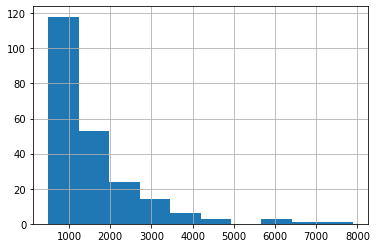

In [47]:
mask = tmp['orders_cnt'] > 500
print(mask.mean())
tmp[mask]['orders_cnt'].hist()

In [48]:
tmp = df_clean.groupby('pickupH3').size().rename('orders_cnt').reset_index()

mask = tmp['orders_cnt'] > 500
tmp = tmp[mask]

city = "Doha"
locator = geopy.geocoders.Nominatim(user_agent="MyCoder")
location = locator.geocode(city)
location = [location.latitude, location.longitude]
map_ = folium.Map(location=location, tiles="cartodbpositron", zoom_start=11)

lcm = LinearColormap(['red', 'green'], vmin=np.log(tmp['orders_cnt'].min()), vmax=np.log(tmp['orders_cnt'].max()))

for idx, row in tmp.iterrows():
    folium.Polygon(
        h3.h3_to_geo_boundary(row['pickupH3']), fill=True,
        fill_color=lcm(np.log(row['orders_cnt'])),
        color=lcm(np.log(row['orders_cnt'])),
        tooltip=folium.Tooltip(f'Hex with {row["orders_cnt"]} orders')
    ).add_to(map_)

map_

In [42]:
tmp.max()

pickupH3      89536bdae93ffff
orders_cnt               7888
dtype: object